In [1]:
import numpy as np
import dedalus.public as d3
import dedalus.core as d4
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import pathlib
import subprocess
import h5py
import glob

In [3]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

The problem is non-dimensionalized using the box height and freefall time, so
the resulting thermal diffusivity and viscosity are related to the Prandtl
and Rayleigh numbers as:

    kappa = (Rayleigh * Prandtl)**(-1/2)
    nu = (Rayleigh / Prandtl)**(-1/2)

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""

logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 16, 1
Nx, Nz = 512, 32
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)
B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d)")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 0")
problem.add_equation("m(z=0) = 0")
problem.add_equation("d(z=Lz) = 1")
problem.add_equation("m(z=Lz) = -3")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(d, name='dry buoyancy')
snapshots.add_task(m, name='moist buoyancy')
snapshots.add_task(B, name='buoyancy')
snapshots.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots.add_task(0.5*d3.dot(u,u), name='KE')
snapshots.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2023-06-13 15:45:24,615 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 29s, Rate: 4.4e+00/s
2023-06-13 15:45:25,549 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 10s, Rate: 1.1e+01/s
2023-06-13 15:45:26,565 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 2s, Remaining: 9s, Rate: 1.2e+01/s
2023-06-13 15:45:27,677 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 3s, Remaining: 8s, Rate: 1.2e+01/s
2023-06-13 15:45:28,693 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 4s, Remaining: 6s, Rate: 1.2e+01/s
2023-06-13 15:45:29,712 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 5s, Remaining: 5s, Rate: 1.2e+01/s
2023-06-13 15:45:30,726 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 6s, Remaining: 4s, Rate: 1.2e+01/s
2023-06-13 15:45:31,738 subsystems 0/1 INFO :: Building subpro

In [6]:
print(subprocess.check_output("find snapshots | sort", shell=True).decode())

snapshots
snapshots/snapshots_s1.h5
snapshots/snapshots_s2.h5
snapshots/snapshots_s3.h5
snapshots/snapshots_s4.h5



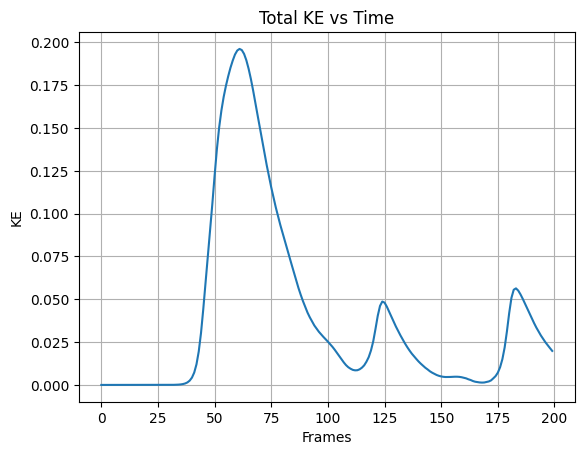

In [3]:
files = sorted(glob.glob('snapshots/*.h5'))
fig, ax = plt.subplots()

with h5py.File(files[0], mode='r') as file:
    KEs = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:]
        KEs=np.append(KEs,KE,axis=0)

ax.plot(np.arange(len(KEs[:,0,0])), KEs[:,0,0])

ax.set_title('Total KE vs Time')
ax.grid(True)
ax.set_xlabel('Frames')
ax.set_ylabel('KE')

plt.savefig('Total_KE_vs_Time')

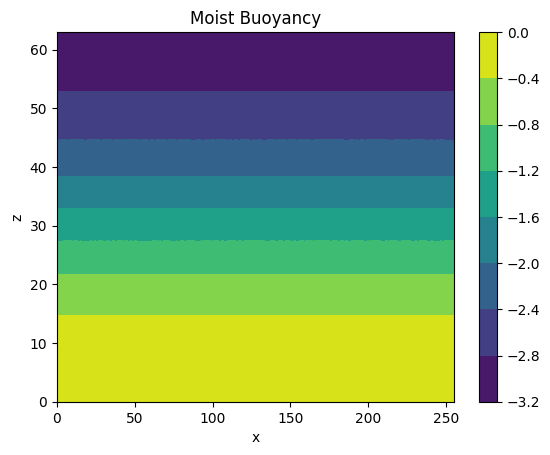

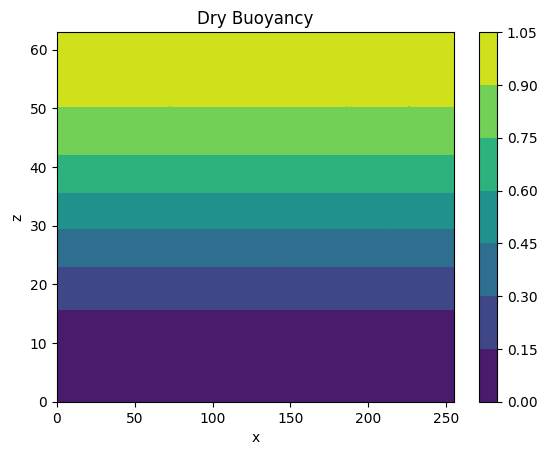

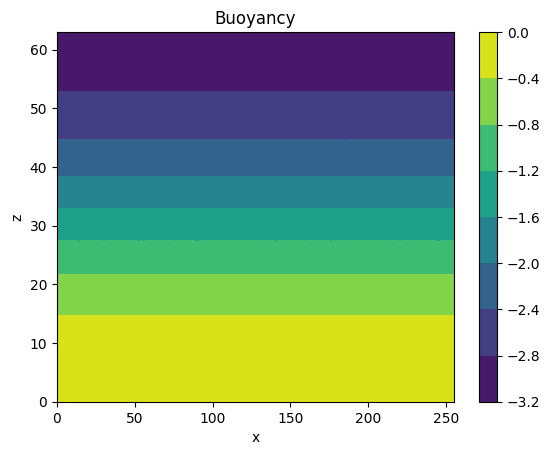

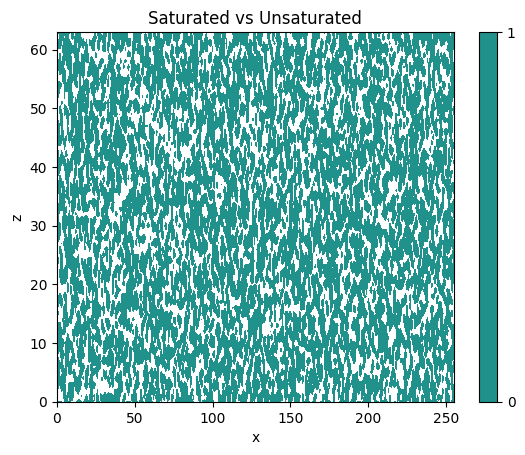

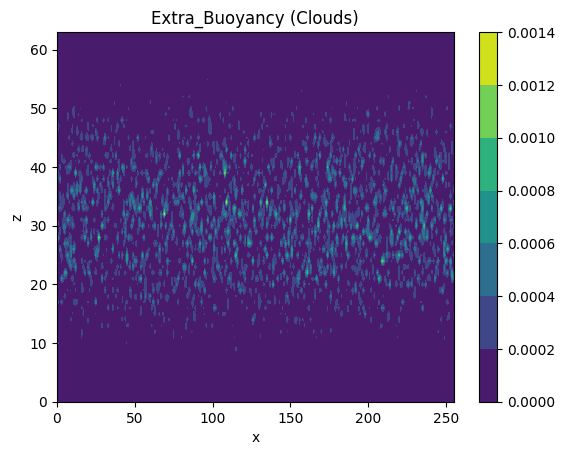

In [10]:
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    saturation=moist_buoyancy-dry_buoyancy+Vaisala*z
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)

    
    # Plotting moist buoyancy
    plt.figure()
    plt.contourf(np.arange(len(moist_buoyancy[-1, :, 1])), np.arange(len(z[0,:])), moist_buoyancy[0,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Moist Buoyancy')
    plt.show()
    
    # Plotting dry buoyancy
    plt.figure()
    plt.contourf(np.arange(len(dry_buoyancy[-1, :, 1])), np.arange(len(z[0,:])), dry_buoyancy[0,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Dry Buoyancy')
    plt.show()
    
    # Plotting buoyancy
    plt.figure()
    plt.contourf(np.arange(len(buoyancy[-1, :, 1])), np.arange(len(z[0,:])), buoyancy[0,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Buoyancy')
    plt.show()
    
    # Plotting saturated region
    plt.figure()
    plt.contourf(np.arange(len(saturation[-1, :, 1])), np.arange(len(z[0,:])), saturation[0,:,:].T, levels=[0,1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Saturated vs Unsaturated')
    plt.show()
    

    # Plotting extra buoyancy
    plt.figure()
    plt.contourf(np.arange(len(extra_buoyancy[-1, :, 1])), np.arange(len(z[0,:])), extra_buoyancy[0,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Extra_Buoyancy (Clouds)')
    plt.show()

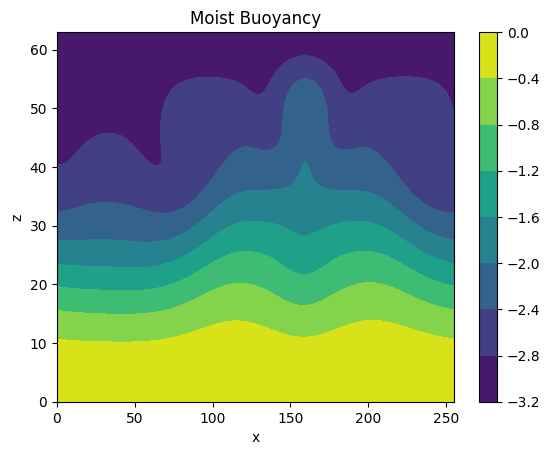

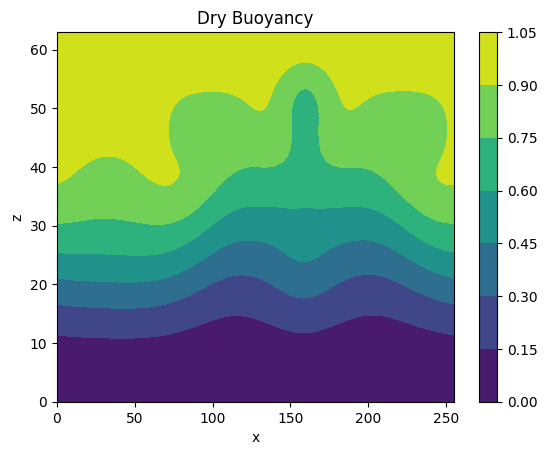

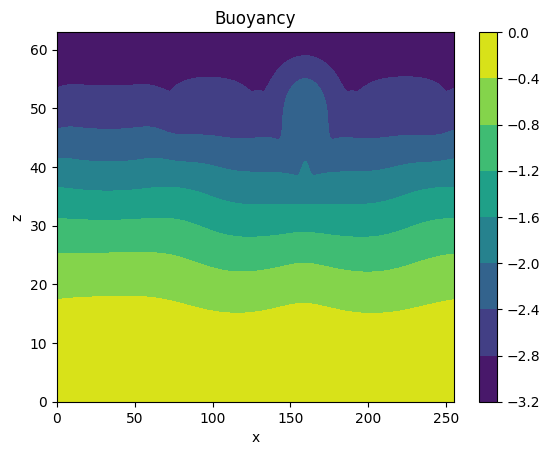

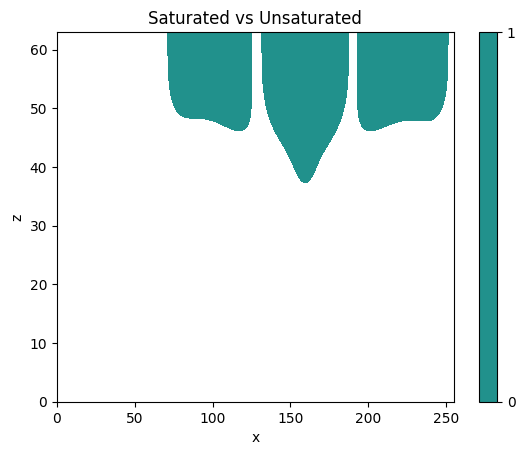

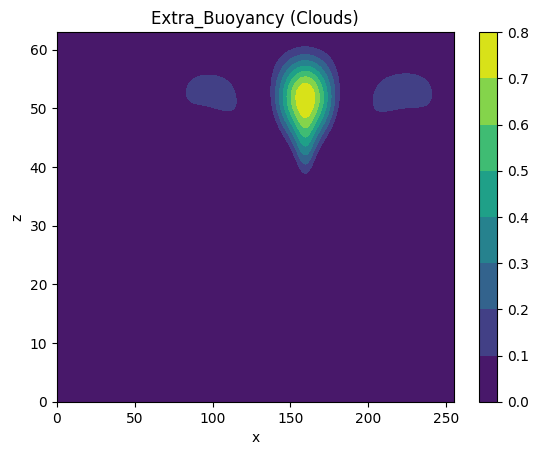

In [11]:
with h5py.File('snapshots/snapshots_s4.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    saturation=moist_buoyancy-dry_buoyancy+Vaisala*z
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)

    
    # Plotting moist buoyancy
    plt.figure()
    plt.contourf(np.arange(len(moist_buoyancy[-1, :, 1])), np.arange(len(z[0,:])), moist_buoyancy[-1,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Moist Buoyancy')
    plt.show()
    
    # Plotting dry buoyancy
    plt.figure()
    plt.contourf(np.arange(len(dry_buoyancy[-1, :, 1])), np.arange(len(z[0,:])), dry_buoyancy[-1,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Dry Buoyancy')
    plt.show()
    
    # Plotting buoyancy
    plt.figure()
    plt.contourf(np.arange(len(buoyancy[-1, :, 1])), np.arange(len(z[0,:])), buoyancy[-1,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Buoyancy')
    plt.show()
    
    # Plotting saturated region
    plt.figure()
    plt.contourf(np.arange(len(saturation[-1, :, 1])), np.arange(len(z[0,:])), saturation[-1,:,:].T, levels=[0,1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Saturated vs Unsaturated')
    plt.show()
    

    # Plotting extra buoyancy
    plt.figure()
    plt.contourf(np.arange(len(extra_buoyancy[-1, :, 1])), np.arange(len(z[0,:])), extra_buoyancy[-1,:,:].T)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Extra_Buoyancy (Clouds)')
    plt.show()


2023-06-13 16:07:39,911 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-06-13 16:07:39,914 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


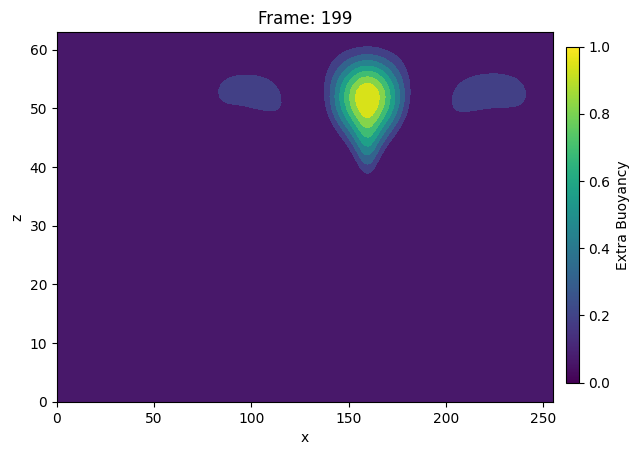

In [12]:
files = sorted(glob.glob('snapshots/*.h5'))
with h5py.File(files[0], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
    buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
    extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)
    clouds = np.where(extra_buoyancy < 0, 0, extra_buoyancy)
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :] 
        dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
        buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)
        extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*z)
        cloud = np.where(extra_buoyancy < 0, 0, extra_buoyancy)
        clouds=np.append(clouds,cloud,axis=0)
        
fig, ax = plt.subplots()
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define colorbar axes position

def animate(frame):
    ax.clear()
    ax.contourf(clouds[frame, :, : ].T)
    ax.set_title('Frame: {}'.format(frame))
    ax.set_xlabel('x')  # Add x-axis label
    ax.set_ylabel('z')  # Add y-axis label
    vmin = np.min(clouds[frame, :, :])
    vmax = np.max(clouds[frame, :, :])
    cb = plt.colorbar(ax.collections[0], cax=cax)
    cb.set_label('Extra Buoyancy')

# Call animate method
animation = FuncAnimation(fig, animate, frames=len(clouds), interval=100, blit=False)
animation.save('clouds_unstable.gif', writer='imagemagick')
# Display the plot
plt.show()

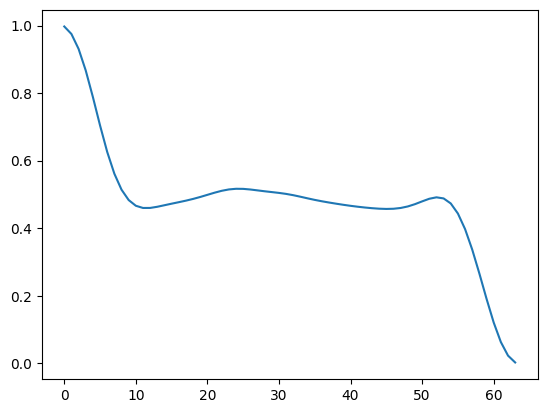

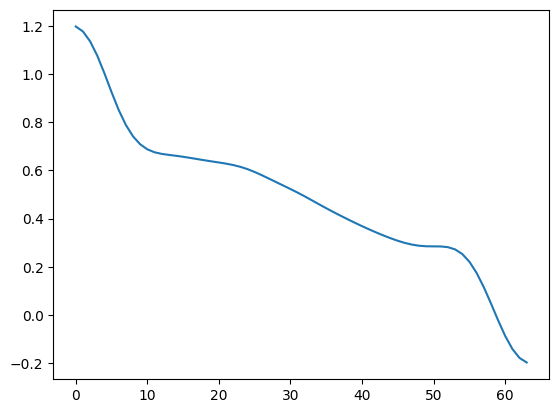

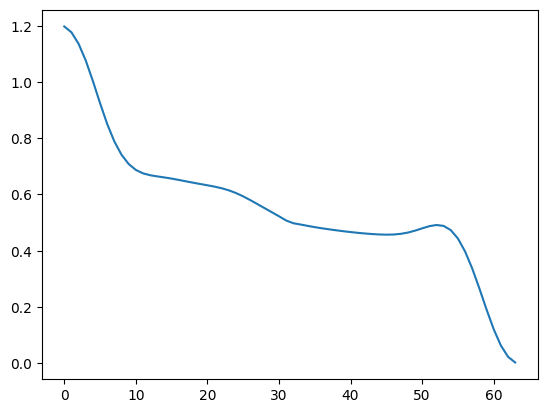

In [9]:
with h5py.File('snapshots/snapshots_s4.h5', 'r') as file:
    moist_buoyancy=file['tasks']['moist buoyancy'][:,:,:]
    avgbm=np.mean(moist_buoyancy,axis=1)
    plt.plot(np.arange(len(avgbm[-2,:])),avgbm[-2,:])
    plt.show()
    dry_buoyancy=file['tasks']['dry buoyancy'][:,:,:]
    dry_buoyancy=dry_buoyancy-Vaisala*z
    avgbd=np.mean(dry_buoyancy,axis=1)
    plt.plot(np.arange(len(avgbd[-2,:])),avgbd[-2,:])
    plt.show()
    avgb=np.maximum(avgbd,avgbm)
    plt.plot(np.arange(len(avgb[-2,:])),avgb[-2,:])
    plt.show()

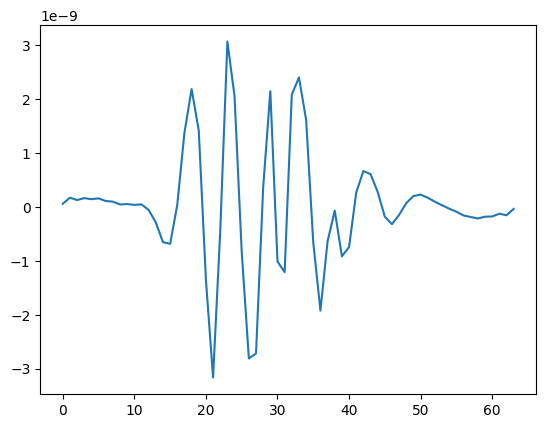

In [10]:
# avg vorticity over time, changing
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgv1=np.mean(vorticity,axis=1)
    plt.plot(np.arange(len(avgv1[2,:])),avgv1[2,:])
    plt.show()

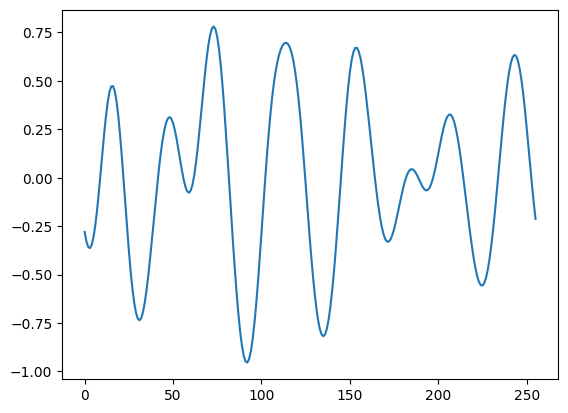

In [11]:
# avg vorticity over time, changing
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgv2=np.mean(vorticity,axis=2)
    plt.plot(np.arange(len(avgv2[-1,:])),avgv2[-1,:])
    plt.show()
   

2023-06-12 17:51:11,275 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-06-12 17:51:11,278 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


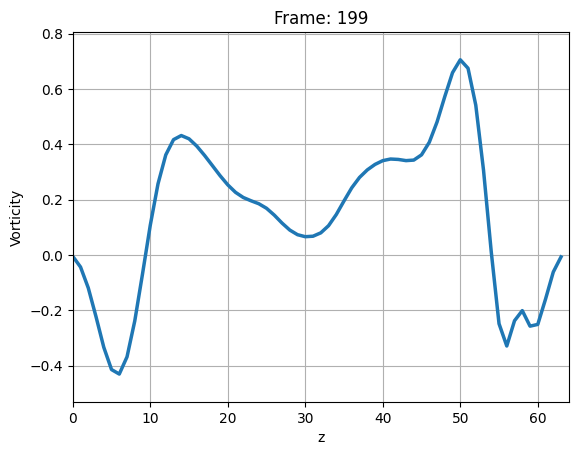

In [12]:
# Avg vorticity(z) time animated
files = sorted(glob.glob('snapshots/*.h5'))
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

with h5py.File(files[0], mode='r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgvs=np.mean(vorticity,axis=1)
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        vorticity=file['tasks']['vorticity'][:,:,:]
        avgv1=np.mean(vorticity,axis=1)
        avgvs=np.append(avgvs,avgv1,axis=0)
        
def update(frame):
    line.set_data(np.arange(len(avgvs[frame, :])), avgvs[frame, :])
    ax.set_xlim(0, len(avgvs[0, :]))
    ax.set_ylim(np.min(avgvs[frame, :])-0.1,np.max(avgvs[frame, :])+0.1)
    ax.set_title('Frame: {}'.format(frame))
    ax.grid(True)  # Add gridlines
    line.set_linewidth(2.5)  # Change line width
    ax.set_xlabel('z')  # Add x-axis label
    ax.set_ylabel('Vorticity')  # Add y-axis label
    return line,

animation = FuncAnimation(fig, update, frames=len(avgvs), interval=100, blit=True)
animation.save('avg vorticity(z).gif', writer='imagemagick')
plt.show()